1. Dense Net + scSE block을 적용시킨 모델을 사용하기로 하였다.
2. Fully Connected Convolutional Network, 다시 말하면 encoder-decoder의 구조로 구성 되어있는 것을 이용해서 featuremap들을 뽑아내는데, channel wise feature또한 도출 해 내야 할 필요가 있기 때문에 squeeze & excite Block을 적용한다.
3. 모델의 마지막 출력층으로 sigmoid를 사용


### Hyperparameters

In [ ]:
!pip install pydicom
!pip install albumentations==0.4.6

In [ ]:
# Hyperparameters
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-2
BATCH_SIZE = 4
NUM_EPOCHS = 77
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
LOAD_MODEL = False
PIN_MEMORY = True
NUM_WORKERS = 1
TRAIN_IMAGE_DIR = '/content/drive/Shareddrives/Kaggle_MOAI2021/data/train/DICOM'
TRAIN_MASK_DIR = '/content/drive/Shareddrives/Kaggle_MOAI2021/data/train/Label'
TEST_IMAGE_DIR = '/content/drive/Shareddrives/Kaggle_MOAI2021/data/test'

CHECKPOINT_DIR = '/content/drive/Shareddrives/Kaggle_MOAI2021/checkpoints/DenseSCSE02_checkpoint.pth.tar'
FILENAME = 'DenseSCSE02_checkpoint.pth.tar'


### Utils

In [ ]:
import cv2
from glob import glob
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from pydicom import dcmread
import matplotlib.image as mpimg

def get_mask_bool(mask, type = None):
    mask_1 = mask < 0.00784314
    mask_2 = mask >= 0.00392157
    mask_3 = np.logical_and(mask_1, mask_2)
    if type == 'tumor':
        mask = (mask >= 0.00784314).astype(float)
    elif type == 'organ':
        mask = mask_3.astype(float)
    elif type == "all":
        mask = (mask!=0).astype(float)
    else:
        mask = (mask < 0.00392157).astype(float)
    if 1.0 not in mask:
      return False
    else:
      return True
      
def list_with(type, image_dir, mask_dir):
  dcom_dirs = np.array(sorted(glob(image_dir + '/*/*')))
  mask_dirs = np.array(sorted(glob(mask_dir + '/*/*')))
  imgs, masks = [],[]
  if type == 'tumor':
    for idx, dir in enumerate(mask_dirs):
      mask = mpimg.imread(dir)
      mask = np.around(mask, 8)
      if get_mask_bool(mask, 'tumor'):
        imgs.append(dcom_dirs[idx])
        masks.append(mask_dirs[idx])
  elif type == 'organ':
    for idx, dir in enumerate(mask_dirs):
      mask = mpimg.imread(dir)
      mask = np.around(mask, 8)
      if get_mask_bool(mask, 'organ'):
        imgs.append(dcom_dirs[idx])
        masks.append(mask_dirs[idx])
  else:
    for idx, dir in enumerate(mask_dirs):
      mask = mpimg.imread(dir)
      mask = np.around(mask, 8)
      if get_mask_bool(mask, 'all'):
        imgs.append(dcom_dirs[idx])
        masks.append(mask_dirs[idx])

  return imgs, masks



In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import pydicom

def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def window_image(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(path, window_widht, window_level, channel):
    image_medical = pydicom.dcmread(path)
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = window_image(image_hu.copy(), window_level, window_widht)
    image_window_norm = resize_normalize(image_window)


    image_window_norm = np.expand_dims(image_window_norm, axis=-1)   # (512, 512, 1)
    if channel == 3:
      image_ths = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)
    else:
      image_ths = image_window_norm
    return image_ths

In [ ]:
import torch
import argparse
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def str2bool(v):
    if v.lower() in ['true', 1]:
        return True
    elif v.lower() in ['false', 0]:
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save_checkpoint(state, filename = FILENAME):
    root = '/content/drive/Shareddrives/Kaggle_MOAI2021/checkpoints'
    print("=>saving checkpoint...")
    torch.save(state, root + '/' + filename)

def load_checkpoint(checkpoint, model):
    print("=>loading checkpoint...")
    model.load_state_dict(checkpoint['state_dict'])

def get_mask(mask, type = None):
    mask_1 = mask < 0.00784314
    mask_2 = mask >= 0.00392157
    mask_3 = np.logical_and(mask_1, mask_2)
    if type == 'tumor':
        mask = (mask >= 0.00784314).astype(float)
    elif type == 'organ':
        mask = mask_3.astype(float)
    elif type == "all":
        mask = (mask!=0).astype(float)
    else:
        mask = (mask < 0.00392157).astype(float)
    return mask

def get_loaders(train_dir,valid_dir, batch_size, train_transform, valid_transform, num_workers = 1, pin_memory = True):
    # 매번 validataion dataset을 새롭게 설정해 준다고 하면 (전체 dataset에서 비율을 정해서 해줌)
    train_ds = MOAIDataset(
        train_dir,
        transform = train_transform
    )
    
    train_loader = DataLoader(
        train_ds,
        batch_size = batch_size, shuffle = True,
        num_workers = num_workers, pin_memory=pin_memory
    )

    valid_ds = MOAIDataset(
        valid_dir,
        transform = valid_transform
    )

    valid_loader = DataLoader(
        valid_ds, 
        batch_size = batch_size, shuffle = True,
        num_workers = num_workers, pin_memory = pin_memory
    )

    return train_loader, valid_loader

def check_accuracy(loader, scheduler, model, device = "cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()  # unet모델의 가중치를 학습하는게 아니라 evaluation 단계에 들어갔음을 의미하는 명령어

    with torch.no_grad():
        for image, mask in loader:
            image = image.to(device)
            mask = mask.permute(0, 3, 1, 2).to(device)
            print('making predictions...')
            if SIGMOID:
              predictions = model(image.float())
            else:
              predictions = torch.sigmoid(model(image.float()))
            print("prediction made...")

            result = (predictions > 0.5)[0].float().cpu().permute(1, 2, 0).detach().numpy()
            visualize_mask(to_cpu(predictions)[0].permute(1, 2, 0).numpy())
            visualize_mask(result)

            predictions = (predictions > 0.5).float()
            num_correct += (predictions == mask).sum()
            num_pixels += torch.numel(predictions)
            dice_score += (2 * (predictions * mask).sum()) / ((predictions + mask).sum() + 1e-9)
            
    scheduler.step(dice_score/len(loader))
        
    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.3f}")
    print(f"Got DICE Score : {dice_score/len(loader)}")
    model.train()

def visualize(inputs, outputs, masks, channel):
  if torch.is_tensor(inputs):
    inputs = inputs.data.detach().cpu()

  if torch.is_tensor(outputs):
    outputs = (outputs).data.detach().cpu()
    outputs = (outputs > 0.5).float().numpy()
    
  if torch.is_tensor(masks):
    masks = masks.data.detach().cpu()
  

  if channel == 1:
    for i in range(BATCH_SIZE):
      imgs = [inputs[i,:,:,0], outputs[i,0,:,:], masks[i,:,:,0]]
      plt.figure(figsize = (6, 6))
      for j in range(len(imgs)):
        plt.subplot(1, len(imgs), j+1)
        plt.imshow(imgs[j])
      plt.show()
  elif channel == 2:
    for i in range(BATCH_SIZE):
      imgs = [inputs[i,0,:,:], outputs[i][:,:,0],masks[i,:,:,0],outputs[i][:,:,1], masks[i,:,:,1]]
      plt.figure(figsize = (10, 10))
      for j in range(len(imgs)):
        plt.subplot(1, len(imgs), j+1)
        plt.imshow(imgs[j])
      plt.show()
  
  else:
    for i in range(BATCH_SIZE):
      imgs = [inputs[i].permute(1, 2, 0)[:,:,0], outputs[i][:,:,0], outputs[i][:,:,1], outputs[i][:,:,2], outputs[i], masks[i]]
      plt.figure(figsize = (10, 10))
      for j in range(len(imgs)):
        plt.subplot(1, len(imgs), j+1)
        plt.imshow(imgs[j])
      plt.show()


def iou_score(output, target):
  #shape = (batchsize, 512, 512, 3)
    smooth = 1e-6

    if torch.is_tensor(output):
        output = output.data.detach().cpu().numpy()
    
    if torch.is_tensor(target):
        target = target.data.detach().cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5

    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)

def dice_coef(output, target):
    smooth = 1e-6

    output = output.view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / (output.sum() + target.sum() + smooth)

def calc_weights(mask_dir):
  nSamples = [0,0,0]
  for idx, dir in enumerate(mask_dir):
    mask = mpimg.imread(dir)
    mask = np.round(mask, 8)
    if get_mask_bool(mask, 'tumor'):
      nSamples[2] += 1
    if get_mask_bool(mask, 'organ'):
      nSamples[1] += 1
    nSamples[0] += 1
  normedWeights = [1-(x/sum(nSamples)) for x in nSamples]
  normedWeights = torch.FloatTensor(normedWeights).to(DEVICE)

  return normedWeights
    

### Dataset

In [ ]:
import cv2
from glob import glob
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from pydicom import dcmread
import matplotlib.image as mpimg
#from utils import get_mask

class MOAIDataset(Dataset):
    def __init__(self, dir, transform = None):
        self.mask_dir = dir
        self.file_no = list(map(lambda x: x.split('/')[-2] +'/'+ (x.split('/')[-1].split('.')[0] + '.dcm'),self.mask_dir))
        self.image_dir = list(map(lambda x: TRAIN_IMAGE_DIR + '/'+ x, self.file_no))
        self.transform = transform

    
    def __len__(self):
        return len(self.image_dir)
    
    def __getitem__(self, index):
        img_path = self.image_dir[index]  # .dcm으로 저장된 DCM format의 CT 데이터
        mask_path = self.mask_dir[index]  # .png로 저장된 PNG format의 ground truth data
        

        image = read_dicom(img_path, 100, 50, 1)
        mask = mpimg.imread(mask_path)
        mask = np.around(mask, 8)

        m_bg = get_mask(mask)
        m_tu = get_mask(mask, 'tumor')
        m_or = get_mask(mask, 'organ')

        m_bg = np.expand_dims(m_bg, axis = -1)
        m_tu = np.expand_dims(m_tu, axis = -1)
        m_or = np.expand_dims(m_or, axis = -1)
        m_fn = np.concatenate([m_bg, m_or, m_tu], axis = -1)
        #m_fn = np.concatenate([m_or, m_tu], axis = -1)
        #m_fn = np.zeros((512, 512, 1))
        #m_fn[m_tu == 1] = 2
        #m_fn[m_or == 1] = 1

        
        # mask = np.array(cv2.imread(mask_path)[:,:,0]) # shape = (512, 512)

        if self.transform is not None:
            augmentations = self.transform(image = image, mask = m_fn)
            image = augmentations['image']
            m_fn = augmentations['mask']

        return image, m_fn.float()

### BCEDice Loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BCEDiceLoss(nn.Module):
    def __init__(self, t_normedWeights, v_normedWeights):
        super().__init__()
        self.t_weight = t_normedWeights
        self.v_weight = v_normedWeights

    def forward(self, inputs, targets, mode):
        if mode == 'train':
          bce = F.binary_cross_entropy(inputs, targets, weight = self.t_weight, reduction = 'mean')
          smooth = 1e-6

          inputs = (inputs > 0.5)
          targets = (targets > 0.5)

          dims = (1, 2)
          for i in range(3):
            input, target = inputs[:, :, :, i], targets[:, :, :, i]
            intersection = torch.sum(input * target, dims) * self.t_weight[i]
            cardinality = torch.sum(input + target, dims) * self.t_weight[i]
        else:
          bce = F.binary_cross_entropy(inputs, targets, weight = self.v_weight, reduction = 'mean')
          smooth = 1e-6

          inputs = (inputs > 0.5)
          targets = (targets > 0.5)

          dims = (1, 2)
          for i in range(3):
            input, target = inputs[:, :, :, i], targets[:, :, :, i]
            intersection = torch.sum(input * target, dims) * self.v_weight[i]
            cardinality = torch.sum(input + target, dims) * self.v_weight[i]

        

        dice_score = 2. * (smooth+intersection) / (cardinality + smooth)
        dice_score = torch.mean(1. - dice_score)

        return 0.5 *(bce + dice_score)

### scSE Block

In [ ]:
import torch
import torch.nn as nn

class SCSEModule(nn.Module):
    def __init__(self, in_channels, mode = 'add', reduction=2):
        super().__init__()
        self.mode = mode
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(nn.Conv2d(in_channels, 1, 1), nn.Sigmoid())

    def forward(self, x):
        if self.mode == 'cat':
            return nn.cat((x * self.cSE(x), x * self.sSE(x)), dim = 1)
        elif self.mode == 'max':
            return nn.max((x*self.cSE, x*self.sSE), dim = 1)
        else:
          return x * self.cSE(x) + x * self.sSE(x)

class Attention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attention = SCSEModule(in_channels = in_channels)
    
    def forward(self, x):
        return self.attention(x)

### Dense Net Model Architecture

In [ ]:
import torch
import torch.nn as nn

def center_crop(layer, max_height, max_width):
    _, _, h, w = layer.size()
    xy1 = (w - max_width) // 2
    xy2 = (h - max_height) // 2
    return layer[:, :, xy2:(xy2 + max_height), xy1:(xy1 + max_width)]
    
class DenseLayer(nn.Sequential):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        self.add_module('norm', nn.BatchNorm2d(in_channels))
        self.add_module('relu', nn.ReLU(True))
        self.add_module('conv', nn.Conv2d(in_channels, growth_rate, kernel_size=5,
                                          stride=1, padding=2,bias=True))
        self.add_module('drop', nn.Dropout2d(0.2))

    def forward(self, x):
        return super().forward(x)


class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.layers = nn.ModuleList([DenseLayer(
            in_channels + i*growth_rate, growth_rate)
            for i in range(n_layers)])

    def forward(self, x):
        if self.upsample:
            new_features = []
            #we pass all previous activations into each dense layer normally
            #But we only store each dense layer's output in the new_features array
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1)
                new_features.append(out)
            return torch.cat(new_features,1)
        else:
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1) # 1 = channel axis
            return x


class TransitionDown(nn.Sequential):
    def __init__(self, in_channels):
        super().__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(in_channels, in_channels,
                                          kernel_size=1, stride=1,
                                          padding=0, bias=True))
        self.add_module('drop', nn.Dropout2d(0.2))
        self.add_module('maxpool', nn.MaxPool2d(2))

    def forward(self, x):
        return super().forward(x)


class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convTrans = nn.ConvTranspose2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=3, stride=2, padding=0, bias=True)

    def forward(self, x, skip):
        out = self.convTrans(x)
        out = center_crop(out, skip.size(2), skip.size(3))
        out = torch.cat([out, skip], 1)
        return out


class Bottleneck(nn.Sequential):
    def __init__(self, in_channels, growth_rate, n_layers):
        super().__init__()
        self.add_module('bottleneck', DenseBlock(
            in_channels, growth_rate, n_layers, upsample=True))

    def forward(self, x):
        return super().forward(x)

In [ ]:
import torch
import torch.nn as nn



class FCDenseNet(nn.Module):
    def __init__(self, in_channels=1, down_blocks=(5,5,5,5,5),
                 up_blocks=(5,5, 5,5,5), bottleneck_layers=4,
                 growth_rate=2, out_chans_first_conv=48, n_classes=3, att_type = 'scsc'):
        super().__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks
        cur_channels_count = 0
        skip_connection_channel_counts = []

        ## First Convolution ##

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels,
                  out_channels=out_chans_first_conv, kernel_size=3,
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv

        #####################
        # Downsampling path #
        #####################

        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        self.AttentionDown = nn.ModuleList([])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0,cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))

            self.AttentionDown.append(Attention(cur_channels_count))

            

        #####################
        #     Bottleneck    #
        #####################

        self.add_module('bottleneck',Bottleneck(cur_channels_count,
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels

        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        self.AttentionUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i],
                    upsample=True))
            
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels
            self.AttentionUp.append(Attention(prev_block_channels))

            

        ## Final DenseBlock ##

        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1],
                upsample=False))
      
        cur_channels_count += growth_rate*up_blocks[-1]
        
        self.AttentionUp.append(Attention(cur_channels_count))

        ## Sigmoid ## -> classifier layer -> 0에서 1사이의 확률값으로 반환

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
               out_channels=n_classes, kernel_size=1, stride=1,
                   padding=0, bias=True)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.firstconv(x)

        skip_connections = []
        for i in range(len(self.down_blocks)):
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)
            out = self.AttentionDown[i](out)

        out = self.bottleneck(out)

        for i in range(len(self.up_blocks)):
            skip = skip_connections.pop()
            out = self.transUpBlocks[i](out, skip)
            out = self.denseBlocksUp[i](out)
            out = self.AttentionUp[i](out)

        out = self.finalConv(out)
        out = self.sigmoid(out)

        return out


def FCDenseNet57(n_classes):
    return FCDenseNet(
        in_channels=3, down_blocks=(4, 4, 4, 4, 4),
        up_blocks=(4, 4, 4, 4, 4), bottleneck_layers=4,
        growth_rate=12, out_chans_first_conv=48, n_classes=n_classes)


def FCDenseNet67(n_classes):
    return FCDenseNet(
        in_channels=3, down_blocks=(5, 5, 5, 5, 5),
        up_blocks=(5, 5, 5, 5, 5), bottleneck_layers=5,
        growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)


def FCDenseNet103(n_classes):
    return FCDenseNet(
        in_channels=3, down_blocks=(4,5,7,10,12),
        up_blocks=(12,10,7,5,4), bottleneck_layers=15,
        growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

# 가장 성능이 좋은 FCDenseNet103을 이용해서 Attention Module로서 scSE를 적용시켜 준 모델을 사용하였다.
# 최종 출력에서는 dim = 1을 기준으로 

def FCDSCSE01(n_classes, att_type = 'scse'):
  return FCDenseNet(
      in_channels = 1, down_blocks = (4,4,4,4,4),
      up_blocks= (4,4,4,4,4), bottleneck_layers = 4,
      growth_rate = 8, out_chans_first_conv = 16, n_classes = n_classes, att_type = 'scsc'
  )

def FCDSCSE02(n_classes, att_type = 'scse'):
  return FCDenseNet(
      in_channels=1, down_blocks=(4,5,7,10,12),
      up_blocks=(12,10,7,5,4), bottleneck_layers=15,
      growth_rate=2, out_chans_first_conv=48, n_classes=n_classes, att_type = 'scsc'
  )

def FCDSCSE03(n_classes, att_type = 'scse'):
  return FCDenseNet(
      in_channels=1, down_blocks=(4,5,7,10,12),
      up_blocks=(12,10,7,5,4), bottleneck_layers=15,
      growth_rate=2, out_chans_first_conv=48, n_classes=n_classes, att_type = 'scsc'
  )

### TRAIN
- 할당된 device가 cpu인 경우에는 torch.LongTensor으로 배정해 주는 것이 가능하고, 할당된 device가 cuda인 경우에는 torch.cuda.LongTensor을 이용해 주어야 한다.

=>Training for epoch 0


  0%|          | 0/1280 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/1280 [00:02<?, ?it/s, loss=0.723, iou=0.0283]

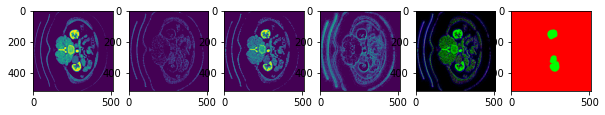

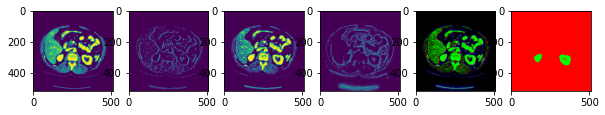

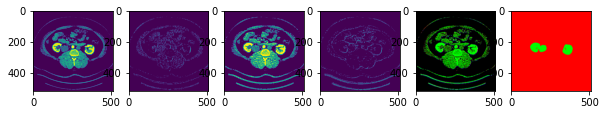

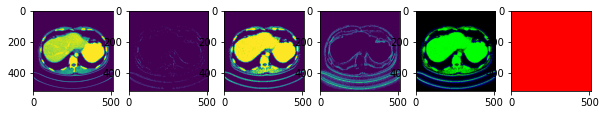

  4%|▍         | 50/1280 [01:38<39:01,  1.90s/it, loss=-.0458, iou=0.876]

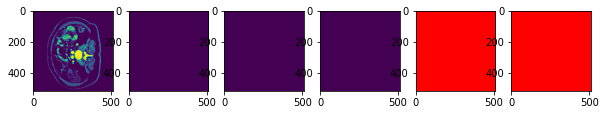

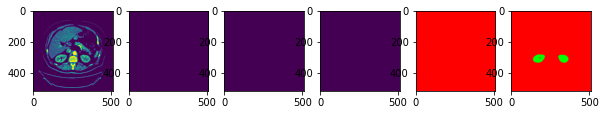

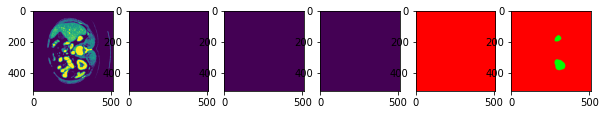

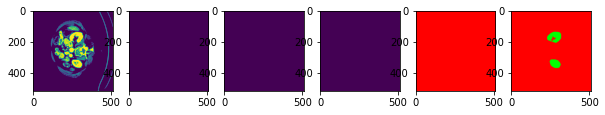

  8%|▊         | 100/1280 [03:17<37:45,  1.92s/it, loss=-.166, iou=0.92] 

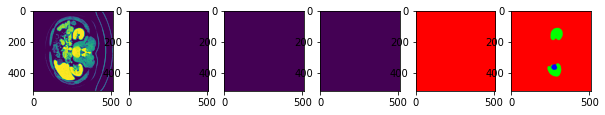

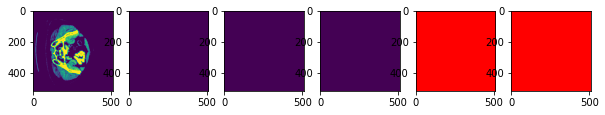

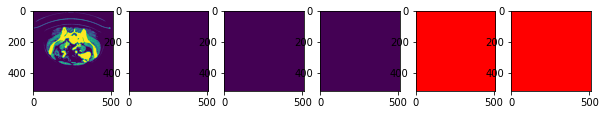

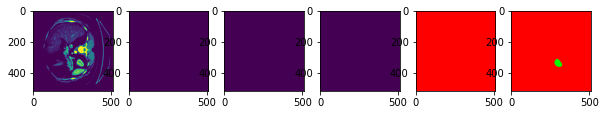

 12%|█▏        | 150/1280 [04:56<36:08,  1.92s/it, loss=-.194, iou=0.936]

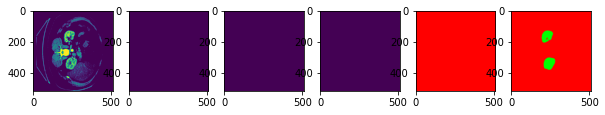

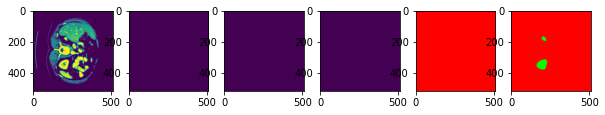

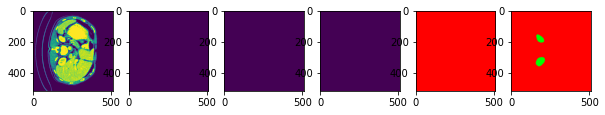

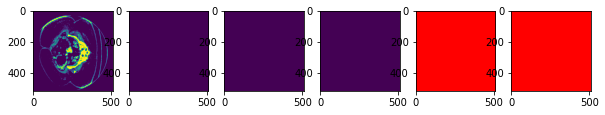

 16%|█▌        | 200/1280 [06:35<34:28,  1.92s/it, loss=-.206, iou=0.945]

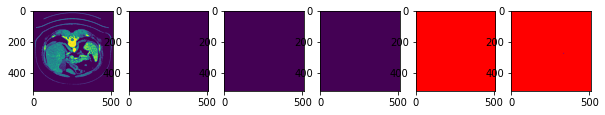

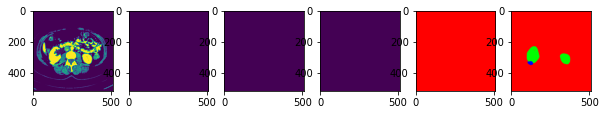

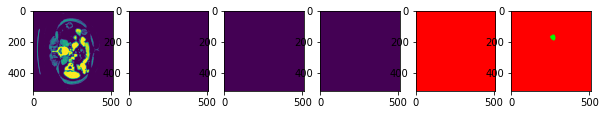

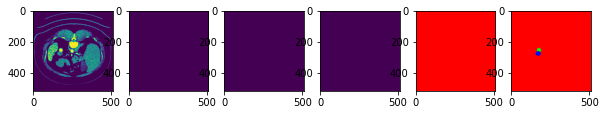

 20%|█▉        | 250/1280 [08:13<32:56,  1.92s/it, loss=-.215, iou=0.95]

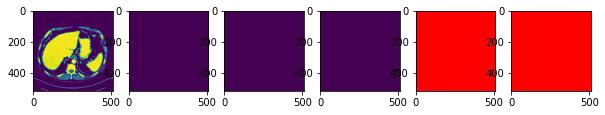

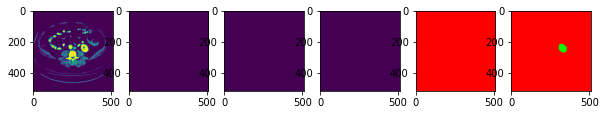

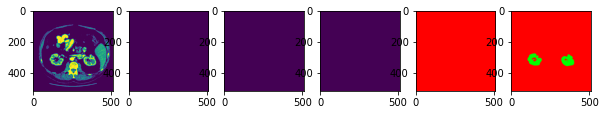

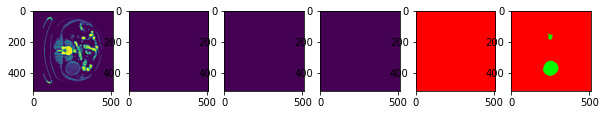

 23%|██▎       | 300/1280 [09:52<31:23,  1.92s/it, loss=-.221, iou=0.953]

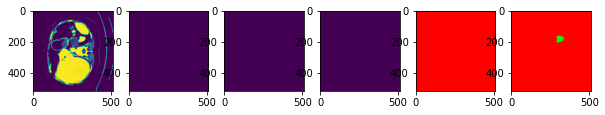

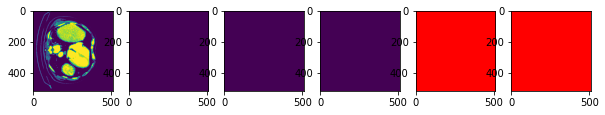

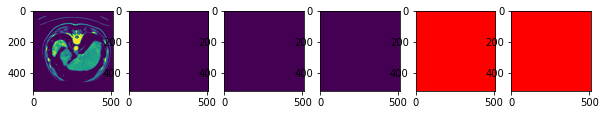

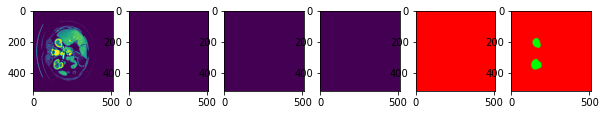

 27%|██▋       | 350/1280 [11:31<29:42,  1.92s/it, loss=-.22, iou=0.955]

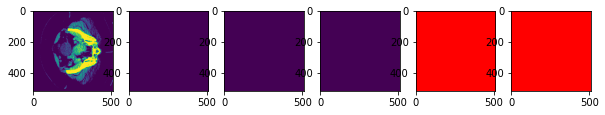

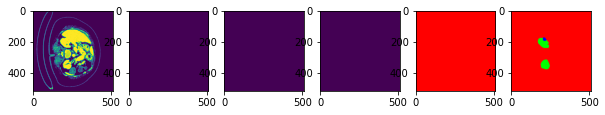

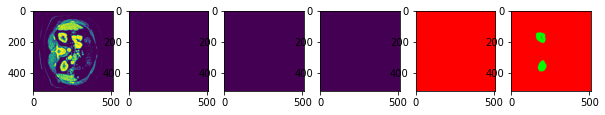

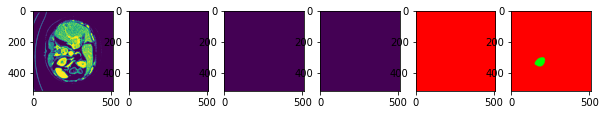

 31%|███       | 392/1280 [12:54<29:14,  1.98s/it, loss=-.224, iou=0.956]


KeyboardInterrupt: ignored

In [ ]:
import os
from collections import OrderedDict
from glob import glob

import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose, OneOf
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2

def train(train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    model.train()
    loop = tqdm(train_loader)

    for idx, (image, target) in enumerate(loop):
        image = image.to(DEVICE)
        target = target.to(DEVICE)

        # compute output
        outputs = model(image)
        output = outputs.permute(0, 2, 3, 1)
        # (4, 512, 512, 3)
    
        loss = criterion(output, target, mode = 'train')
        #loss = criterion(output, target)
        iou = iou_score(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), image.shape[0])
        avg_meters['iou'].update(iou, image.shape[0])

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        loop.set_postfix(postfix)
        if idx % 50 == 0:
          visualize(image, output, target, channel = 3)
       

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])
    
def validate(valid_loader, model, criterion, scheduler):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    # switch to evaluate mode
    model.eval()
    loop = tqdm(valid_loader)

    with torch.no_grad():
        for iter, (image, target) in enumerate(loop):
            image = image.to(DEVICE)
            target = target.to(DEVICE)

            # compute output
            outputs = model(image)
            output = outputs.permute(0, 2, 3, 1)

            loss = criterion(output, target, mode = 'valid')
            #loss = criterion(output, target)
            iou = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), image.shape[0])
            avg_meters['iou'].update(iou, image.shape[0])

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
            ])
            loop.set_postfix(postfix)
            if iter %50 == 0:
              visualize(image,output, target, channel = 3)
            #pbar.set_postfix(postfix)
            #pbar.update(1)
        #pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])

def main():
    model = FCDSCSE02(n_classes = 3).to(DEVICE)
    
    optimizer = optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum = 0.95, weight_decay = 1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2)

    

    
    if LOAD_MODEL:
      load_checkpoint(torch.load(CHECKPOINT_DIR), model)

    
    for epoch in range(NUM_EPOCHS):

      dcom_dirs = np.array(sorted(glob(TRAIN_IMAGE_DIR + '/*/*')))
      mask_dirs = np.array(sorted(glob(TRAIN_MASK_DIR + '/*/*')))

      mask_train_dirs, mask_valid_dirs = train_test_split(mask_dirs, test_size = 0.2, shuffle = True)

      t_normedWeights, v_normedWeights = calc_weights(mask_train_dirs), calc_weights(mask_valid_dirs)

      
      #criterion = nn.BCELoss().to(DEVICE)
      criterion = BCEDiceLoss(t_normedWeights, v_normedWeights).to(DEVICE)

  

      train_transform = Compose([
        transforms.RandomRotate90(always_apply = True),
        transforms.Flip(),
        transforms.Resize(512, 512),
        transforms.Normalize(mean = 0.0, std = 1.0, max_pixel_value = 1.0),
        ToTensorV2()])
    
      val_transform = Compose([
        transforms.Resize(512, 512),
        transforms.Normalize(mean = 0.0, std = 1.0, max_pixel_value = 1.0),
        ToTensorV2()
        ])

      train_loader, valid_loader = get_loaders(
        mask_train_dirs, mask_valid_dirs, BATCH_SIZE,
        train_transform, val_transform, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY
        )


      best_iou, trigger = 0, 0

      print("=>Training for epoch %d" %epoch)

      train_log = train(train_loader, model, criterion, optimizer)
      valid_log = validate(valid_loader, model, criterion, scheduler)

      scheduler.step(valid_log['loss'])

      trigger += 1

      if valid_log['iou'] > best_iou:
          checkpoint = {
              "state_dict" : model.state_dict(),
              "optimizer" : optimizer.state_dict()
                }
          save_checkpoint(checkpoint)
          best_iou = valid_log['iou']
          print("=> SAVED BEST IOU")
          trigger = 0
        
      torch.cuda.empty_cache()


if __name__ == "__main__":
    main()



